In [20]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_absolute_error
from numpy import array

In [21]:
def rnn(train, test, file):
  print("Train/Test Radio:",train, test)
  # 2. Đọc file csv và gắng index với Price
  # Load the data
  df = pd.read_csv(file, index_col='Date')
  df = df.dropna() # Drop missing values
  # Removing all other columns
  df1 = df.reset_index(drop=True)['Price']
  # 3. Scaler data
  scaler = MinMaxScaler(feature_range=(0, 1))  # Create an instance of MinMaxScaler, which will scale the data between 0 and 1
  df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))  # Perform min-max scaling on df1
  # 4. Chia train test
  train_size = int(train * len(df1))
  test_size = int(test * len(df1))
  train_data = df1[:train_size]
  test_data = df1[train_size:train_size+test_size]
  # 5. Hàm Create Dataset
  import numpy
  # convert an array of values into a dataset matrix
  def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
      a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
      dataX.append(a)
      dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)
  #6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
  time_step = 100
  X_train, y_train = create_dataset(train_data, time_step)
  X_test, ytest = create_dataset(test_data, time_step)
  # 7. Reshape input to be [samples, time steps, features] which is required for LSTM
  X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
  X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

  # 8. Define  Model
  model = Sequential()
  model.add(SimpleRNN(50, input_shape=(time_step, 1)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error',optimizer='adam')
  # 9. Fit mô hình với dữ liệu train
  model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)
  # 10. Dự báo dữ liệu test
  train_predict=model.predict(X_train)
  y_pred=model.predict(X_test)

  # 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
  train_predict=scaler.inverse_transform(train_predict)
  y_pred=scaler.inverse_transform(y_pred)
  ytest_original = scaler.inverse_transform(ytest.reshape(-1, 1))


  # 12. Đánh giá độ chính xác thuật toán
  # Calculate RMSE for validation and testing sets
  test_rmse = np.sqrt(np.mean((y_pred - ytest_original)**2))

  # Calculate MAPE for validation and testing sets
  test_mape = np.mean(np.abs((ytest_original - y_pred) / ytest_original)) * 100

  # Calculate MAE for validation and testing sets
  test_mae = mean_absolute_error(ytest_original, y_pred)

  # Print evaluation metrics
  print('Testing RMSE:', test_rmse)
  print('Testing MAPE:', test_mape)
  print('Testing MAE:', test_mae)

  # 13. Dự báo 30 ngày tiếp theo
  x_input = test_data[60:].reshape(1, -1) # into a 2d array numpy
  x_input.shape
  temp_input = list(x_input)
  # Flatten the list (it was nested within another list)
  temp_input = temp_input[0].tolist()

  lst_output = []
  n_steps = 100
  n_sequences = 1
  i = 0

  # Loop to predict the next 30 days
  while i < 90:
      if len(temp_input) > 100:
          x_input = np.array(temp_input[-100:])
          print("{} day input {}".format(i, x_input))
          # Reshape x_input to a 2D array with 1 row
          x_input = x_input.reshape(1, -1)
          # Reshape x_input to the shape (1, 100, 1)
          x_input = x_input.reshape((n_sequences, n_steps, 1))
          # Predict the next value using the model
          yhat = model.predict(x_input, verbose=0)
          print("{} day output {}".format(i, yhat))
          # Add the predicted value to temp_input
          temp_input.extend(yhat[0].tolist())
          # Remove the first element from temp_input to maintain the length
          temp_input = temp_input[1:]
          # print(temp_input)
          # Add the predicted value to the output list
          lst_output.extend(yhat.tolist())
          i += 1
      else:
        # Addded
          print(len(temp_input))
          n_steps = len(temp_input)
          # Convert temp_input to a numpy array
          x_input = np.array(temp_input)
          x_input = x_input.reshape((n_sequences, n_steps, 1))
          yhat = model.predict(x_input, verbose=0)
          print(yhat[0])
          temp_input.extend(yhat[0].tolist())
          print(len(temp_input))
          lst_output.extend(yhat.tolist())
          i += 1

  lst_output_30 = lst_output[:30]
  lst_output_60 = lst_output[29:61]
  lst_output_90 = lst_output[60:]


  # 14.Vẽ hình
  train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
  plt.plot(scaler.inverse_transform(train_data))
  test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
  plt.plot(test_data_index,scaler.inverse_transform(test_data))
  test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
  plt.plot(test_data_index,(y_pred))
  prediect_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
  plt.plot(prediect_data_index_30,scaler.inverse_transform(lst_output_30))
  prediect_data_index_60 = pd.RangeIndex(start=len(df1)+28, stop=len(df1)+60, step=1)
  plt.plot(prediect_data_index_60,scaler.inverse_transform(lst_output_60))
  prediect_data_index_90 = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
  plt.plot(prediect_data_index_90,scaler.inverse_transform(lst_output_90))

  plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days','Predict90days'])
  plt.show()

# FPT

Train/Test Radio: 0.7 0.3
Epoch 1/100
24/24 [==============================] - 2s 45ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 2/100
24/24 [==============================] - 1s 37ms/step - loss: 1.9061e-04 - val_loss: 0.0027
Epoch 3/100
24/24 [==============================] - 1s 36ms/step - loss: 1.7256e-04 - val_loss: 0.0016
Epoch 4/100
24/24 [==============================] - 1s 38ms/step - loss: 1.6274e-04 - val_loss: 0.0021
Epoch 5/100
24/24 [==============================] - 0s 20ms/step - loss: 1.5903e-04 - val_loss: 0.0013
Epoch 6/100
24/24 [==============================] - 0s 20ms/step - loss: 1.5315e-04 - val_loss: 0.0014
Epoch 7/100
24/24 [==============================] - 1s 21ms/step - loss: 1.4044e-04 - val_loss: 0.0010
Epoch 8/100
24/24 [==============================] - 0s 20ms/step - loss: 1.4766e-04 - val_loss: 0.0012
Epoch 9/100
24/24 [==============================] - 0s 21ms/step - loss: 1.3390e-04 - val_loss: 0.0012
Epoch 10/100
24/24 [======================

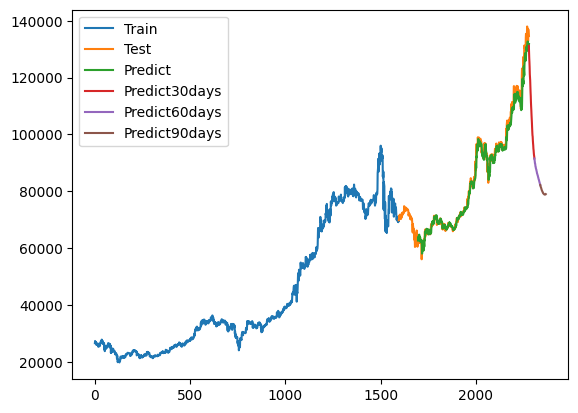

Train/Test Radio: 0.8 0.2
Epoch 1/100
27/27 [==============================] - 2s 40ms/step - loss: 0.0017 - val_loss: 0.0072
Epoch 2/100
27/27 [==============================] - 1s 35ms/step - loss: 2.2884e-04 - val_loss: 0.0053
Epoch 3/100
27/27 [==============================] - 1s 38ms/step - loss: 2.0090e-04 - val_loss: 0.0054
Epoch 4/100
27/27 [==============================] - 1s 34ms/step - loss: 1.8209e-04 - val_loss: 0.0040
Epoch 5/100
27/27 [==============================] - 1s 19ms/step - loss: 1.6184e-04 - val_loss: 0.0040
Epoch 6/100
27/27 [==============================] - 1s 19ms/step - loss: 1.5522e-04 - val_loss: 0.0039
Epoch 7/100
27/27 [==============================] - 1s 20ms/step - loss: 1.4576e-04 - val_loss: 0.0032
Epoch 8/100
27/27 [==============================] - 1s 19ms/step - loss: 1.3948e-04 - val_loss: 0.0033
Epoch 9/100
27/27 [==============================] - 1s 20ms/step - loss: 1.3359e-04 - val_loss: 0.0026
Epoch 10/100
27/27 [======================

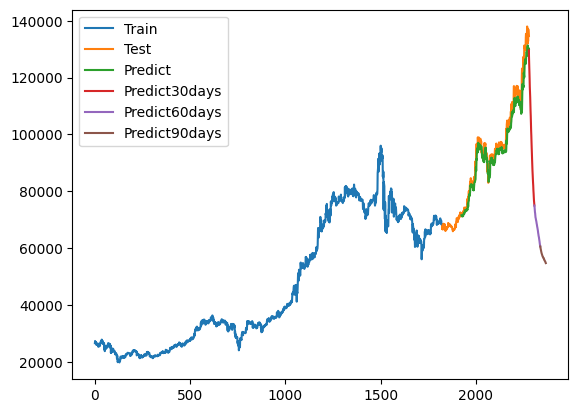

Train/Test Radio: 0.9 0.1
Epoch 1/100
31/31 [==============================] - 2s 27ms/step - loss: 0.0061 - val_loss: 0.0195
Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 4.3773e-04 - val_loss: 0.0146
Epoch 3/100
31/31 [==============================] - 1s 28ms/step - loss: 3.2072e-04 - val_loss: 0.0109
Epoch 4/100
31/31 [==============================] - 1s 33ms/step - loss: 2.8438e-04 - val_loss: 0.0086
Epoch 5/100
31/31 [==============================] - 1s 33ms/step - loss: 2.5418e-04 - val_loss: 0.0063
Epoch 6/100
31/31 [==============================] - 1s 33ms/step - loss: 2.2890e-04 - val_loss: 0.0056
Epoch 7/100
31/31 [==============================] - 1s 30ms/step - loss: 2.1368e-04 - val_loss: 0.0053
Epoch 8/100
31/31 [==============================] - 1s 20ms/step - loss: 1.9938e-04 - val_loss: 0.0031
Epoch 9/100
31/31 [==============================] - 1s 20ms/step - loss: 2.2074e-04 - val_loss: 0.0053
Epoch 10/100
31/31 [======================

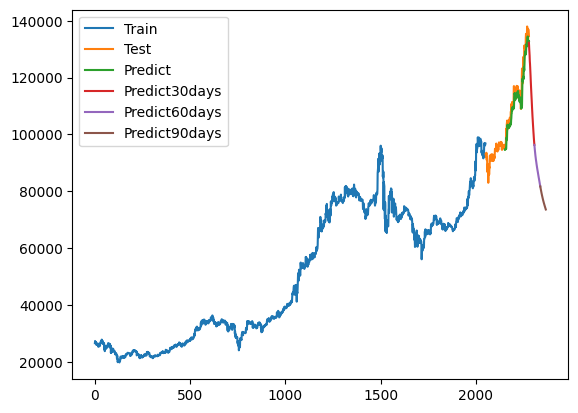

In [22]:
file = "fpt_data_final.csv"
rnn(0.7, 0.3, file)
rnn(0.8, 0.2, file)
rnn(0.9, 0.1, file)

# ELC

Train/Test Radio: 0.7 0.3
Epoch 1/100
24/24 [==============================] - 2s 31ms/step - loss: 0.0240 - val_loss: 0.0058
Epoch 2/100
24/24 [==============================] - 1s 22ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 3/100
24/24 [==============================] - 1s 21ms/step - loss: 9.1208e-04 - val_loss: 0.0013
Epoch 4/100
24/24 [==============================] - 1s 23ms/step - loss: 8.2003e-04 - val_loss: 0.0013
Epoch 5/100
24/24 [==============================] - 1s 22ms/step - loss: 7.4547e-04 - val_loss: 0.0010
Epoch 6/100
24/24 [==============================] - 1s 23ms/step - loss: 6.7578e-04 - val_loss: 9.7468e-04
Epoch 7/100
24/24 [==============================] - 1s 26ms/step - loss: 6.5058e-04 - val_loss: 9.4538e-04
Epoch 8/100
24/24 [==============================] - 1s 38ms/step - loss: 6.0956e-04 - val_loss: 8.5409e-04
Epoch 9/100
24/24 [==============================] - 1s 38ms/step - loss: 5.6936e-04 - val_loss: 8.4204e-04
Epoch 10/100
24/24 [==========

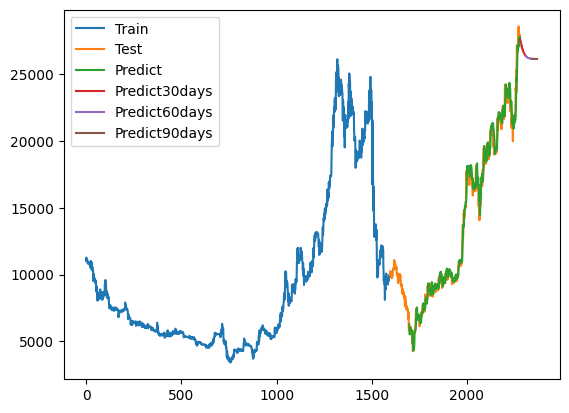

Train/Test Radio: 0.8 0.2
Epoch 1/100
27/27 [==============================] - 2s 29ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 2/100
27/27 [==============================] - 1s 21ms/step - loss: 5.5986e-04 - val_loss: 0.0012
Epoch 3/100
27/27 [==============================] - 1s 20ms/step - loss: 4.9415e-04 - val_loss: 9.3642e-04
Epoch 4/100
27/27 [==============================] - 1s 21ms/step - loss: 4.6178e-04 - val_loss: 0.0010
Epoch 5/100
27/27 [==============================] - 1s 20ms/step - loss: 4.3858e-04 - val_loss: 9.3674e-04
Epoch 6/100
27/27 [==============================] - 1s 20ms/step - loss: 4.2647e-04 - val_loss: 7.9178e-04
Epoch 7/100
27/27 [==============================] - 1s 20ms/step - loss: 4.0916e-04 - val_loss: 9.1498e-04
Epoch 8/100
27/27 [==============================] - 1s 31ms/step - loss: 4.0958e-04 - val_loss: 7.2894e-04
Epoch 9/100
27/27 [==============================] - 1s 35ms/step - loss: 3.9400e-04 - val_loss: 8.3785e-04
Epoch 10/100
27/27

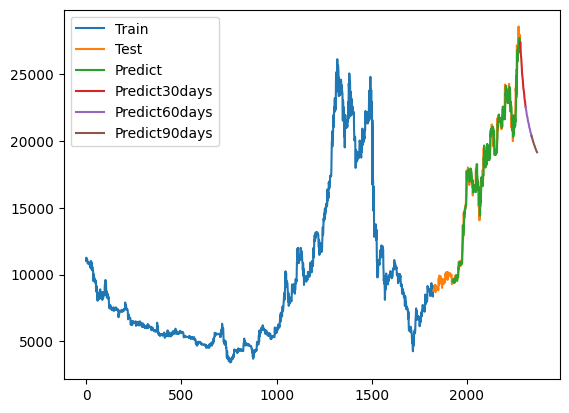

Train/Test Radio: 0.9 0.1
Epoch 1/100
31/31 [==============================] - 2s 26ms/step - loss: 0.0513 - val_loss: 0.0365
Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0025 - val_loss: 0.0075
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 4/100
31/31 [==============================] - 1s 19ms/step - loss: 8.2355e-04 - val_loss: 0.0028
Epoch 5/100
31/31 [==============================] - 1s 19ms/step - loss: 7.0298e-04 - val_loss: 0.0032
Epoch 6/100
31/31 [==============================] - 1s 18ms/step - loss: 6.1861e-04 - val_loss: 0.0025
Epoch 7/100
31/31 [==============================] - 1s 19ms/step - loss: 5.5535e-04 - val_loss: 0.0027
Epoch 8/100
31/31 [==============================] - 1s 19ms/step - loss: 5.1930e-04 - val_loss: 0.0016
Epoch 9/100
31/31 [==============================] - 1s 19ms/step - loss: 4.8997e-04 - val_loss: 0.0016
Epoch 10/100
31/31 [==============================

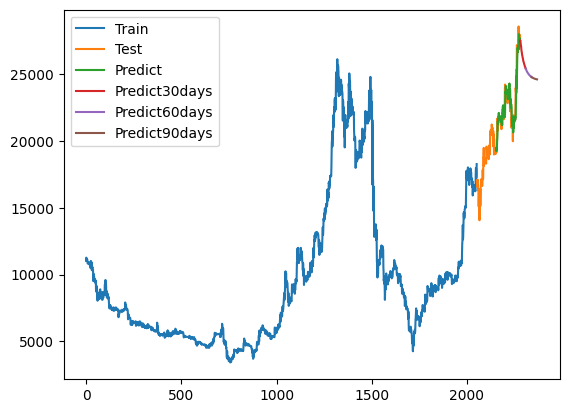

In [23]:
file = "elc_data_final.csv"
rnn(0.7, 0.3, file)
rnn(0.8, 0.2, file)
rnn(0.9, 0.1, file)

# CMG

Train/Test Radio: 0.7 0.3
Epoch 1/100
24/24 [==============================] - 2s 52ms/step - loss: 0.0280 - val_loss: 0.0031
Epoch 2/100
24/24 [==============================] - 1s 37ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 3/100
24/24 [==============================] - 1s 37ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 4/100
24/24 [==============================] - 1s 32ms/step - loss: 8.2807e-04 - val_loss: 0.0013
Epoch 5/100
24/24 [==============================] - 0s 20ms/step - loss: 7.4409e-04 - val_loss: 0.0011
Epoch 6/100
24/24 [==============================] - 0s 21ms/step - loss: 6.7605e-04 - val_loss: 0.0011
Epoch 7/100
24/24 [==============================] - 0s 20ms/step - loss: 6.2421e-04 - val_loss: 9.9025e-04
Epoch 8/100
24/24 [==============================] - 0s 20ms/step - loss: 6.1422e-04 - val_loss: 8.9480e-04
Epoch 9/100
24/24 [==============================] - 0s 21ms/step - loss: 5.4986e-04 - val_loss: 8.9725e-04
Epoch 10/100
24/24 [==================

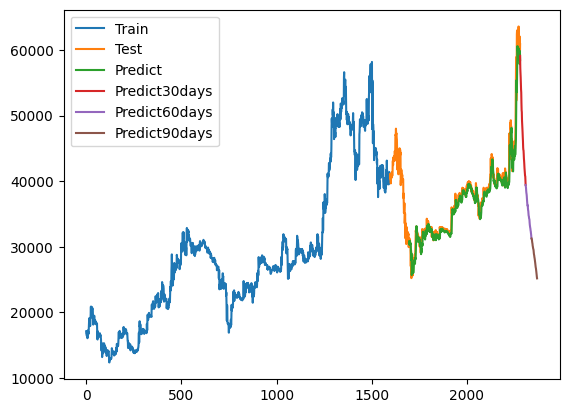

Train/Test Radio: 0.8 0.2
Epoch 1/100
27/27 [==============================] - 2s 28ms/step - loss: 0.0367 - val_loss: 0.0074
Epoch 2/100
27/27 [==============================] - 1s 33ms/step - loss: 0.0034 - val_loss: 0.0045
Epoch 3/100
27/27 [==============================] - 1s 35ms/step - loss: 0.0021 - val_loss: 0.0038
Epoch 4/100
27/27 [==============================] - 1s 34ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 5/100
27/27 [==============================] - 1s 34ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 6/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 7/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 8/100
27/27 [==============================] - 1s 20ms/step - loss: 9.5152e-04 - val_loss: 0.0021
Epoch 9/100
27/27 [==============================] - 1s 19ms/step - loss: 8.6266e-04 - val_loss: 0.0019
Epoch 10/100
27/27 [==============================] - 1s 20ms/step

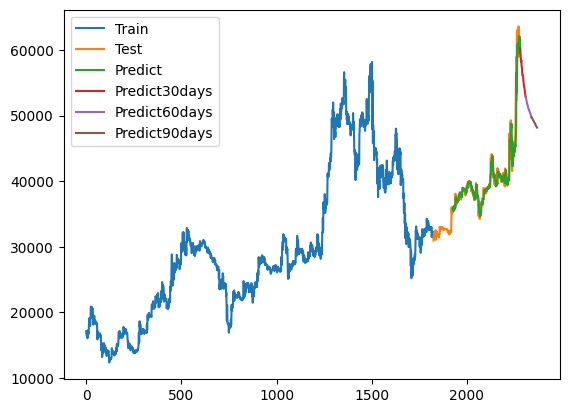

Train/Test Radio: 0.9 0.1
Epoch 1/100
31/31 [==============================] - 2s 29ms/step - loss: 0.0479 - val_loss: 0.0036
Epoch 2/100
31/31 [==============================] - 1s 22ms/step - loss: 7.4745e-04 - val_loss: 0.0029
Epoch 3/100
31/31 [==============================] - 1s 22ms/step - loss: 4.4163e-04 - val_loss: 0.0025
Epoch 4/100
31/31 [==============================] - 1s 21ms/step - loss: 4.0236e-04 - val_loss: 0.0024
Epoch 5/100
31/31 [==============================] - 1s 22ms/step - loss: 3.7935e-04 - val_loss: 0.0022
Epoch 6/100
31/31 [==============================] - 1s 22ms/step - loss: 3.5858e-04 - val_loss: 0.0021
Epoch 7/100
31/31 [==============================] - 1s 21ms/step - loss: 3.4994e-04 - val_loss: 0.0020
Epoch 8/100
31/31 [==============================] - 1s 24ms/step - loss: 3.4413e-04 - val_loss: 0.0019
Epoch 9/100
31/31 [==============================] - 1s 35ms/step - loss: 3.4390e-04 - val_loss: 0.0019
Epoch 10/100
31/31 [======================

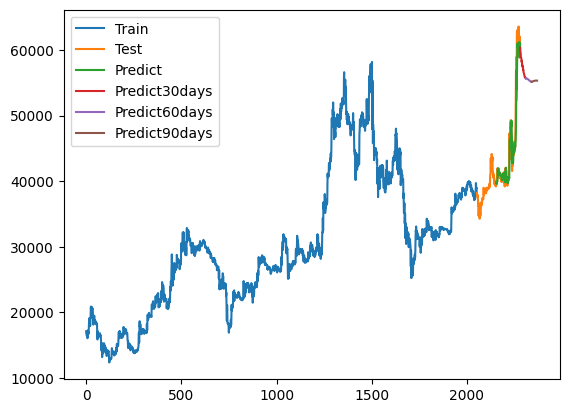

In [24]:
file = "cmg_data_final.csv"
rnn(0.7, 0.3, file)
rnn(0.8, 0.2, file)
rnn(0.9, 0.1, file)